#  FOM ~ $O(m)$

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation 
%matplotlib inline
import time, sys
from scipy.sparse import spdiags
from scipy import sparse
from scipy.sparse.linalg import spsolve
import pickle

In [2]:
def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols

In [3]:
def sine_wave(amp,width,nx,dx,x):
    
    u0 = np.zeros(nx) + 1.0
    u0[1:int(width/dx+1)] = 1.0 + amp/2*(np.sin(2*np.pi/(x[int(width/dx+1)]-x[1])*x[1:int(width/dx+1)]-np.pi/2)+1)
    u0[-1] = u0[0]
    
    return u0

In [4]:
def residual(un,uw,c,idxn1):
    
    # r = -u^{n} + u^{n+1} -dt*f(u^{n+1})
    
    f = c*(uw**2 - uw*uw[idxn1]) 
    
    r = -un + uw + f
    
    return r

In [5]:
def jacobian(u,c,idxn1):

    # J = I - dt*dfdu
    
    diag_comp = 1.0 + c*(2*u - u[idxn1])
    subdiag_comp = np.ones(nx-1)
    subdiag_comp[:-1] = -c*u[1:]
        
    data = np.array([diag_comp, subdiag_comp])
    J = spdiags(data,[0,-1],nx-1,nx-1,format='csr')
    J[0,-1] = -c*u[0]
    
    return J

#     diag_comp = 1.0 + c*(2*u - u[idxn1])
#     subdiag_comp = -c*u
    
#     J = np.diag(diag_comp,0)
#     J[dn1] = subdiag_comp[1:]
#     J[0,-1] = -c*u[0]
    
#     return J

In [6]:
# predictive case
amp = 1.0
width = 1.0

convergence_threshold = 1.0e-8
maxk = 10

nx = 1001
dx = 2.0 / (nx - 1)
nt = 501  
dt = 0.5 / (nt - 1)  

c = dt/dx

x = np.linspace(0, 2, nx)

u0 = sine_wave(amp,width,nx,dx,x)

dn1=kth_diag_indices(np.eye(nx-1),-1)
idxn1=np.zeros(nx-1,dtype='int')
idxn1[1:]=np.arange(nx-2)
idxn1[0]=nx-2

In [7]:
t_total_start = time.time()

u = np.zeros((nt,nx))
u[0] = u0
I = sparse.eye(nx,format='csr')
for n in range(nt-1): 
#     print("")
#     print(n,"th time step:")
    
    uw = u[n,:-1].copy()
    
    r = residual(u[n,:-1],uw,c,idxn1)
    
    for k in range(maxk):
        J = jacobian(uw,c,idxn1)
        
        duw = spsolve(J, -r)
#         duw = np.linalg.solve(J,-r)
        
        uw = uw + duw
        
        r = residual(u[n,:-1],uw,c,idxn1)
    
        R = np.linalg.norm(r)
#         print(k,"th Newton iteration", "R:", R)

        if R < convergence_threshold:
            u[n+1,:-1] = uw.copy()
            u[n+1,-1] = u[n+1,0]
            break
            
    if R >= convergence_threshold:
        print("\n non converged after {}th iteration".format(maxk))
        break
    
#     u[n+1,:-1] = uw.copy()
#     u[n+1,-1] = u[n+1,0]
      
t_total = time.time()-t_total_start
print()
print("Time elapsed: {} sec".format(t_total))

/home/kim101/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])



Time elapsed: 1.0757813453674316 sec


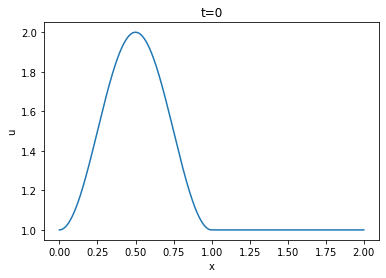

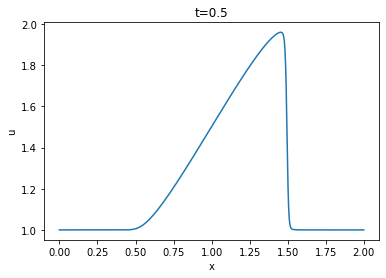

In [8]:
plt.figure()
plt.plot(x,u[0])
plt.xlabel('x')
plt.ylabel('u')
plt.title('t={}'.format(0))
plt.show()

plt.figure()
plt.plot(x,u[-1])
plt.xlabel('x')
plt.ylabel('u')
plt.title('t={}'.format(0.5))
plt.show()

# LS-ROM (g) ~ $O(f^2m)$, where $f$ is a latent dimension

In [9]:
# load POD basis
file_name_POD="./model/POD_v2.p"

POD = pickle.load(open(file_name_POD,'rb'))

phi=np.copy(POD)
phiT=phi.T

POD_basis =phi.shape[1]

In [10]:
def sine_wave(amp,width,nx,dx,x):
    
    u0 = np.zeros(nx) + 1.0
    u0[1:int(width/dx+1)] = 1.0 + amp/2*(np.sin(2*np.pi/(x[int(width/dx+1)]-x[1])*x[1:int(width/dx+1)]-np.pi/2)+1)
    u0[-1] = u0[0]
    
    return u0

In [11]:
def residual_hat(u_hatn,u_hatw,uw,c,phiT,idxn1):
    
    # \hat r = -\hat u^n + \hat u^{n+1} - dt*\phi^T f(\phi \hat u^{n+1})   
    
    f = c*(uw**2 - uw*uw[idxn1]) 
    
    r_hat = -u_hatn + u_hatw + phiT.dot(f)
    
    return r_hat

In [12]:
def jacobian_hat(u,c,phiT,phi,idxn1,I_hat):
    
    # \hat J = \hat I - dt \phi^T Jf \phi
    
    diag_comp = c*(2*u - u[idxn1])
    diag_out = diag_comp*phiT
    
    subdiag_comp = -c*u[1:]
    subdiag_out = subdiag_comp*phiT[:,1:]
    
    last_col = -c*u[0]*phiT[:,0]
    
    phiTJf = diag_out
    phiTJf[:,:-1] += subdiag_out
    phiTJf[:,-1] += last_col

    J_hat = I_hat + phiTJf.dot(phi)
    
    return J_hat

In [13]:
amp = 1.0
width = 1.0

convergence_threshold = 1.0e-8
maxk = 4

nx = 1001
dx = 2.0 / (nx - 1)
nt = 501  
dt = 0.5 / (nt - 1)   

c = dt/dx

x = np.linspace(0, 2, nx)

idxn1 = np.zeros(nx-1,dtype='int')
idxn1[1:] = np.arange(nx-2)
idxn1[0] = nx-2

u0 = sine_wave(amp,width,nx,dx,x)
u_hat0 = np.zeros(POD_basis)

In [22]:
t_total_rom_g_start=time.time()

u_rom_g = np.zeros((nt,nx))
u_rom_g[0] = u0
u_hat = np.zeros((nt,POD_basis))
u_hat[0] = u_hat0
I_hat = np.eye(POD_basis)

for n in range(nt-1): 
#     print("")
#     print(n,"th time step:")
    
    u_hatw = u_hat[n].copy()
  
    uw = u0[:-1] + phi.dot(u_hatw)

    r_hat = residual_hat(u_hat[n],u_hatw,uw,c,phiT,idxn1)
    
    for k in range(maxk):   
        J_hat = jacobian_hat(uw,c,phiT,phi,idxn1,I_hat)
        
        du_hatw = np.linalg.solve(J_hat,-r_hat) 
        
        u_hatw = u_hatw + du_hatw
        
        uw = u0[:-1] + phi.dot(u_hatw)

        r_hat = residual_hat(u_hat[n],u_hatw,uw,c,phiT,idxn1)
        
        res = np.linalg.norm(r_hat)      
#         print(k,"th Newton iteration", "res:", "{:.8e}".format(res))        
        
        if res < convergence_threshold:
            u_hat[n+1] = u_hatw.copy()
            u_rom_g[n+1,:-1] = uw.copy()
            u_rom_g[n+1,-1] = u_rom_g[n+1,0]    
            break
            
    if res >= convergence_threshold:
        print("\n non converged after {}th iteration".format(maxk))
        break

#     u_hat[n+1] = u_hatw.copy()
#     u_rom_g[n+1,:-1] = uw.copy()
#     u_rom_g[n+1,-1] = u_rom_g[n+1,0]

t_total_rom_g=time.time()-t_total_rom_g_start
print()
print("Time elapsed: {} sec".format(t_total_rom_g))


Time elapsed: 0.182844877243042 sec


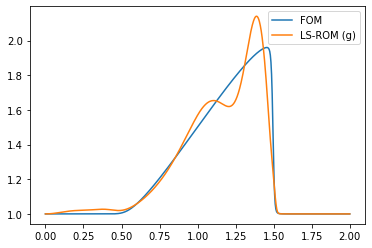

In [27]:
# plot
ts=-1

plt.figure()
plt.plot(x,u[ts],x,u_rom_g[ts])
plt.legend(['FOM','LS-ROM (g)'])
plt.show()

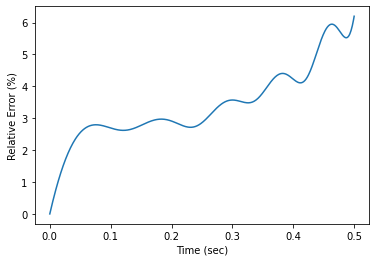

average relative error: 3.600236836397509%

maximum relative error: 6.196376857032859%


In [28]:
rel_err=np.linalg.norm(u-u_rom_g,axis=1)/np.linalg.norm(u,axis=1)*100
avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u-u_rom_g,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u,ord=2,axis=1)**2))*100
max_rel_err = np.max(rel_err)  

plt.plot(dt*np.arange(nt),rel_err)
plt.xlabel('Time (sec)')
plt.ylabel('Relative Error (%)')
plt.show()

print("average relative error: {}%".format(avg_rel_err))
print()
print("maximum relative error: {}%".format(max_rel_err))

In [29]:
# speed-up
speed_up=t_total/t_total_rom_g
print("speed-up: {}".format(speed_up))

speed-up: 5.8835738883593445


# LS-ROM (lspg) ~ $O(f^2m)$

In [30]:
def residual_lspg(uwn,uw,c,idxn1):
    
    f = c*(uw**2 - uw*uw[idxn1])
    
    r = -uwn + uw + f
    
    return r

In [31]:
def jacobian_lspg(u,c,phiT,idxn1):
    
    # J \approx \phi - \Delta t J_f \phi = (I-\Delta t J_f) \phi
    
    diag_comp = 1.0 + c*(2*u - u[idxn1])
    diag_out = (diag_comp*phiT).T
    
    subdiag_comp = -c*u[1:]
    subdiag_out = (subdiag_comp*phiT[:,:-1]).T
    
    top_row = -c*u[0]*phiT[:,-1]
    
    J = diag_out
    J[1:] += subdiag_out
    J[0] += top_row
    
    return J

In [32]:
amp = 1.0
width = 1.0

convergence_threshold = 1.0e-8
maxk = 4

nx = 1001
dx = 2.0 / (nx - 1)
nt = 501 
dt = 0.5 / (nt - 1)  

c = dt/dx

x = np.linspace(0, 2, nx)

idxn1=np.zeros(nx-1,dtype='int')
idxn1[1:]=np.arange(nx-2)
idxn1[0]=nx-2

u0 = sine_wave(amp,width,nx,dx,x)
u_hat0 = np.zeros(POD_basis,dtype='float32')

In [37]:
t_total_rom_lspg_start=time.time()

u_rom_lspg = np.zeros((nt,nx))
u_rom_lspg[0] = u0
u_hat = np.zeros((nt,POD_basis))
u_hat[0] = u_hat0
I_hat = np.eye(POD_basis)

for n in range(nt-1): 
#     print("")
#     print(n,"th time step:")
    
    u_hatw = u_hat[n].copy()
    
    uw = u0[:-1] + phi.dot(u_hatw)
    
    J_lspg = jacobian_lspg(uw,c,phiT,idxn1)
        
    r_lspg = residual_lspg(u_rom_lspg[n,:-1],uw,c,idxn1)
    r = r_lspg.dot(J_lspg)
    
    for k in range(maxk):   
        J = J_lspg.T.dot(J_lspg)
        
        du_hatw = np.linalg.solve(J,-r)
        
        u_hatw = u_hatw + du_hatw
        
        uw = u0[:-1] + phi.dot(u_hatw)
        
        J_lspg = jacobian_lspg(uw,c,phiT,idxn1)
    
        r_lspg = residual_lspg(u_rom_lspg[n,:-1],uw,c,idxn1)
        r = r_lspg.dot(J_lspg)

        res = np.linalg.norm(r)
#         print(k,"th Newton iteration", "res:", "{:.8e}".format(res))
        
        if res < convergence_threshold:
            u_hat[n+1] = u_hatw.copy()
            u_rom_lspg[n+1,:-1] = uw.copy()
            u_rom_lspg[n+1,-1] = u_rom_lspg[n+1,0] 
            break
            
    if res >= convergence_threshold:
        print("\n non converged after {}th iteration".format(maxk))
        break
        
#     u_hat[n+1] = u_hatw.copy()
#     u_rom_lspg[n+1,:-1] = uw.copy()
#     u_rom_lspg[n+1,-1] = u_rom_lspg[n+1,0]        

t_total_rom_lspg=time.time()-t_total_rom_lspg_start
print()
print("Time elapsed: ",t_total_rom_lspg)


Time elapsed:  0.21546387672424316


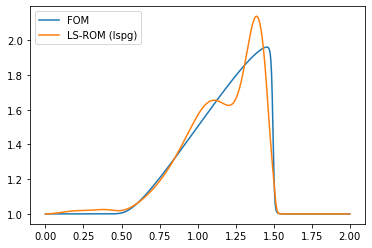

In [38]:
# plot
ts=-1

plt.figure()
plt.plot(x,u[ts],x,u_rom_lspg[ts])
plt.legend(['FOM','LS-ROM (lspg)'])
plt.show()

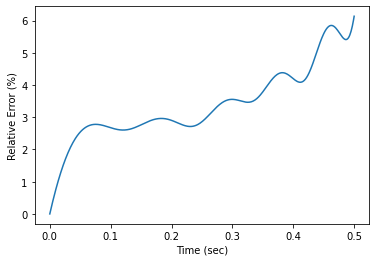

average relative error: 3.573345508073412%

maximum relative error: 6.134322367722707%


In [39]:
rel_err=np.linalg.norm(u-u_rom_lspg,axis=1)/np.linalg.norm(u,axis=1)*100
avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u-u_rom_lspg,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u,ord=2,axis=1)**2))*100
max_rel_err = np.max(rel_err)  

plt.plot(dt*np.arange(nt),rel_err)
plt.xlabel('Time (sec)')
plt.ylabel('Relative Error (%)')
plt.show()

print("average relative error: {}%".format(avg_rel_err))
print()
print("maximum relative error: {}%".format(max_rel_err))

In [40]:
# speed-up
speed_up=t_total/t_total_rom_lspg
print("speed-up: {}".format(speed_up))

speed-up: 4.992861734982367


## Hyper reduction

In [41]:
def DEIM(phi_f, nfeval=None):
    
    ninf=np.NINF
    n,m=np.shape(phi_f)
    if nfeval==None:
        nfeval=m
        
    if nfeval<m:
        print("ill-posed\n")
        print("set # sampling equal to # modes")
        nfeval=m
        
    div,mod=np.divmod(nfeval,m)
    
    I=np.eye(n)
    
    l=0
    ns=div+mod
    u=np.reshape(phi_f[:,l],(n,1))
    p=np.argsort(-np.abs(u),axis=0,kind='stable')[:ns]
#     p=np.argmax(np.abs(u)) # when ns=1
    ep=np.reshape(I[:,p],(n,ns))
    U=u
    P=ep

    ns=div
    for l in range(1,m):
        u=np.reshape(phi_f[:,l],(n,1))
        PT=np.transpose(P)
        c=np.linalg.lstsq(PT@U,PT@u,rcond=None)[0]
        r=np.abs(u-U@c)
        r[p]=ninf
        p=np.append(p,np.argsort(-r,axis=0,kind='stable')[:ns]) # ns!=1
        ep=np.reshape(I[:,p[-ns:]],(n,ns))
        U=np.concatenate((U,u),axis=1)
        P=np.concatenate((P,ep),axis=1)
        
    return p

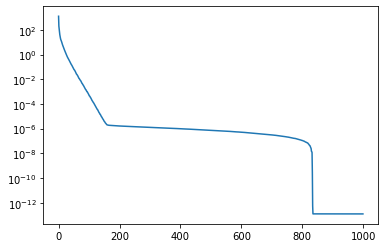

In [42]:
# load snapshot
snapshot_full=pickle.load(open('./data/snapshot_full.p','rb'))
DEIM_snapshot=snapshot_full[:,:-1]

# Do SVD
Ur,Sr,VrT=np.linalg.svd(DEIM_snapshot.T,full_matrices=False)
plt.figure()
plt.semilogy(Sr)
plt.show()

In [43]:
# choose # of DEIM basis and DEIM samples
DEIM_basis=30
DEIM_samples=47

acc=np.sum(Sr[:DEIM_basis]**2)/np.sum(Sr**2)*100
print(acc)
print(np.sum(Sr[:DEIM_basis])/np.sum(Sr)*100)

99.99988675117493
99.69489574432373


In [44]:
# precompute
phi_r=Ur[:,:DEIM_basis]
z=DEIM(phi_r,DEIM_samples)
ZT=np.eye(nx-1,dtype='float32')[z]
Z=ZT.T
precomp1=phi_r@np.linalg.pinv(ZT@phi_r)
precomp=precomp1.T@precomp1

In [45]:
# influential indices
z_union=np.zeros((z.size,2),dtype='int')
for i in range(z.size):
    if z[i]==0:
        z_union[i,0]=0
        z_union[i,1]=nx-2
    else:
        z_union[i,0]=z[i]
        z_union[i,1]=z[i]-1        
z0=z_union[:,0]
z1=z_union[:,1]

z_union=np.unique(z_union.flatten())

z_union0_ind=np.zeros(z0.size,dtype='int')
z_union1_ind=np.zeros(z1.size,dtype='int')
for i in range(z0.size):
    z_union0_ind[i]=np.nonzero(np.isin(z_union,z0[i]))[0]
    z_union1_ind[i]=np.nonzero(np.isin(z_union,z1[i]))[0]

## Subbasis

In [46]:
# Construct subbasis
phi_sb=phi[z_union]
phi_sbT=phi_sb.T

## Efficient version ~ $O(fz^2)$, where $z$ is the number of sampling points

In [47]:
def residual_lspg_hr(uwn_z,u_sb,z0_ind,z1_ind,c):
    
    # u_sb is subnet of u
    # z_union[z0_ind] gives z0, which is z
    # z_union[z1_ind] igves z1, which is z-1
    
    r = -uwn_z + u_sb[z0_ind] + c*(u_sb[z0_ind]**2 - u_sb[z0_ind]*u_sb[z1_ind])
    
    return r

def jacobian_lspg_hr(u_sb,phi_sbT,z0_ind,z1_ind,c):
    
    # phi_sb is subnet of phi
    
    J = ((1.0 + c*(2*u_sb[z0_ind] - u_sb[z1_ind]))*phi_sbT[:,z0_ind]).T + (-c*u_sb[z0_ind]*phi_sbT[:,z1_ind]).T
    
    return J

In [48]:
amp = 1.0
width = 1.0

convergence_threshold = 1.0e-8
maxk = 4

nx = 1001
dx = 2.0 / (nx - 1)
nt = 501 
dt = 0.5 / (nt - 1)  

c = dt/dx

x = np.linspace(0, 2, nx)

idxn1=np.zeros(nx-1,dtype='int')
idxn1[1:]=np.arange(nx-2)
idxn1[0]=nx-2

u0 = sine_wave(amp,width,nx,dx,x)
u_hat0=np.zeros(POD_basis,dtype='float32')

In [49]:
t_total_rom_lspg_hr_start=time.time()

u_rom_lspg_hr = np.zeros((nt,nx))
u_rom_lspg_hr[0] = u0
u_hat = np.zeros((nt,POD_basis))
u_hat[0] = u_hat0
I_hat = np.eye(POD_basis)

for n in range(nt-1): 
#     print("")
#     print(n,"th time step:")
    
    u_hatw = u_hat[n].copy()
    
    uw_sb = u0[z_union] + phi_sb.dot(u_hatw)
    
    J_lspg = jacobian_lspg_hr(uw_sb,phi_sbT,z_union0_ind,z_union1_ind,c)
    J_lspgT = J_lspg.T
        
    r_lspg = residual_lspg_hr(u_rom_lspg_hr[n,z],uw_sb,z_union0_ind,z_union1_ind,c)
    r = J_lspgT.dot(precomp.dot(r_lspg))
    
    for k in range(maxk):   
        J = J_lspgT@precomp@J_lspg
        
        du_hatw = np.linalg.solve(J,-r)
        
        u_hatw = u_hatw + du_hatw
        
        uw_sb = u0[z_union] + phi_sb.dot(u_hatw)
        
        J_lspg = jacobian_lspg_hr(uw_sb,phi_sbT,z_union0_ind,z_union1_ind,c)
        J_lspgT = J_lspg.T
    
        r_lspg = residual_lspg_hr(u_rom_lspg_hr[n,z],uw_sb,z_union0_ind,z_union1_ind,c)
        r = J_lspgT.dot(precomp.dot(r_lspg))
        
        res = np.linalg.norm(r)
#         print(k,"th Newton iteration", "res:", "{:.8e}".format(res))
        
        if res < convergence_threshold:
            u_hat[n+1] = u_hatw.copy()
            u_rom_lspg_hr[n+1,:-1] = u0[:-1] + phi.dot(u_hat[n+1])
            u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]
            break
            
    if res >= convergence_threshold:
        print("\n non converged after {}th iteration".format(maxk))
        break
        
#     u_hat[n+1] = u_hatw.copy()
#     u_rom_lspg_hr[n+1,:-1] = u0[:-1] + phi.dot(u_hat[n+1])
#     u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]

t_total_rom_lspg_hr=time.time()-t_total_rom_lspg_hr_start
print()
print("Time elapsed: {} sec".format(t_total_rom_lspg_hr))


Time elapsed: 0.12458276748657227 sec


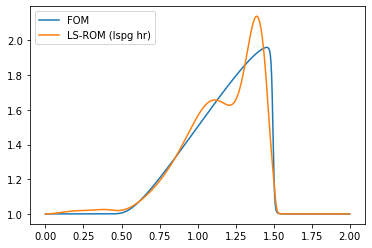

In [50]:
# plot
ts=-1

plt.figure()
plt.plot(x,u[ts],x,u_rom_lspg_hr[ts])
plt.legend(['FOM','LS-ROM (lspg hr)'])
plt.show()

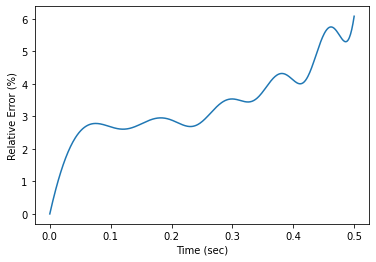

average relative error: 3.532429714295504%

maximum relative error: 6.074687326967075%


In [51]:
rel_err=np.linalg.norm(u-u_rom_lspg_hr,axis=1)/np.linalg.norm(u,axis=1)*100
avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u-u_rom_lspg_hr,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u,ord=2,axis=1)**2))*100
max_rel_err = np.max(rel_err)  

plt.plot(dt*np.arange(nt),rel_err)
plt.xlabel('Time (sec)')
plt.ylabel('Relative Error (%)')
plt.show()

print("average relative error: {}%".format(avg_rel_err))
print()
print("maximum relative error: {}%".format(max_rel_err))

In [52]:
# speed-up
speed_up=t_total/t_total_rom_lspg_hr
print("speed-up: {}".format(speed_up))

speed-up: 8.63507343006633


# Save data to mat file

In [53]:
from scipy.io import savemat, loadmat

In [54]:
savemat("./data/LSROM.mat",mdict={"u_rom_lspg_hr":u_rom_lspg_hr,"u":u})